# Semi-supervised AQI Classification — Co-Training

- Mục tiêu: chạy co-training theo **2 views** (mặc định: view theo pattern thời gian/station và phần còn lại).
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: tự thiết kế VIEW1_COLS / VIEW2_COLS và chứng minh view tốt.

In [14]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/metrics_co_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_co_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

# Optionally set explicit views (list of column names), otherwise None -> auto split
VIEW1_COLS = None
VIEW2_COLS = None

✅ Đã định nghĩa View 1 (6 cols) và View 2 (10 cols)
🚀 Đang chạy Co-training... (Vui lòng đợi trong giây phút)


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.527007,0.355958,383962,500,0.9
1,2,0.529783,0.377415,383462,500,0.9
2,3,0.522211,0.359993,382962,500,0.9
3,4,0.527764,0.383259,382462,500,0.9
4,5,0.526249,0.374695,381962,500,0.9
5,6,0.522211,0.358603,381462,500,0.9
6,7,0.514891,0.358677,380962,500,0.9
7,8,0.518677,0.365178,380462,500,0.9
8,9,0.513377,0.360581,379962,500,0.9
9,10,0.520949,0.380851,379462,500,0.9


📊 Test Accuracy (Ensemble): 0.4738
📊 Test F1-macro (Ensemble): 0.3466


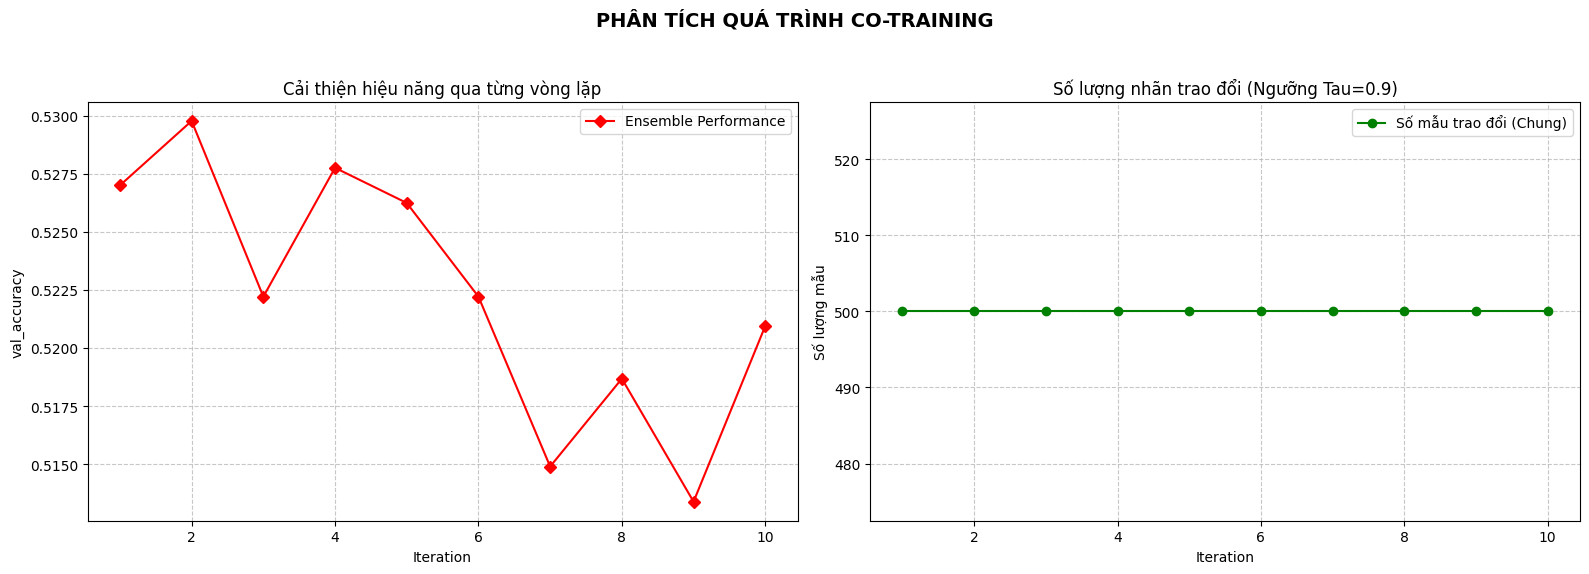

💾 Đã lưu kết quả tại: C:\Users\Speedyservice\air_guard\data\processed\metrics_co_training.json


In [16]:
import sys
import os
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ====================================================
# 1. KHỞI TẠO ĐƯỜNG DẪN VÀ IMPORT
# ====================================================
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.semi_supervised_library import (
    SemiDataConfig, CoTrainingConfig, run_co_training, add_alert_columns
)

# ====================================================
# 2. MÔ TẢ HAI NHÓM ĐẶC TRƯNG (VIEW)
# ====================================================
# View 1: Nhóm Không gian & Thời gian (Spatio-Temporal View)
# Tập trung vào các yếu tố định danh vị trí và chu kỳ thời gian
VIEW1_COLS = ['hour_sin', 'hour_cos', 'dow', 'month', 'is_weekend', 'station']

# View 2: Nhóm Khí tượng & Chất ô nhiễm (Meteorological & Chemical View)
# Tập trung vào các chỉ số đo lường môi trường trực tiếp
VIEW2_COLS = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

print(f"✅ Đã định nghĩa View 1 ({len(VIEW1_COLS)} cols) và View 2 ({len(VIEW2_COLS)} cols)")

# ====================================================
# 3. THIẾT LẬP THAM SỐ VÀ HUẤN LUYỆN
# ====================================================
# Lưu ý: Các biến SEMI_DATASET_PATH, CUTOFF, RANDOM_STATE cần được định nghĩa trước đó trong notebook
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
ct_cfg = CoTrainingConfig(
    tau=0.9,                         # Ngưỡng tin cậy >= 0.9 mới được gán nhãn
    max_iter=10,                     # Tối đa 10 vòng lặp trao đổi
    max_new_per_iter=500,            # Mỗi mô hình chọn tối đa 500 mẫu tốt nhất cho đối phương
    min_new_per_iter=10,             
    val_frac=0.2
)

print("🚀 Đang chạy Co-training... (Vui lòng đợi trong giây phút)")
out = run_co_training(df, data_cfg, ct_cfg, view1_cols=VIEW1_COLS, view2_cols=VIEW2_COLS)

# Trích xuất kết quả
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

# Hiển thị bảng diễn biến
display(history)
print(f"📊 Test Accuracy (Ensemble): {test_metrics['accuracy']:.4f}")
print(f"📊 Test F1-macro (Ensemble): {test_metrics['f1_macro']:.4f}")

# ====================================================
# 4. VẼ BIỂU ĐỒ THEO DÕI DIỄN BIẾN (SỬA LỖI HIỂN THỊ)
# ====================================================
if not history.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Biểu đồ 1: Sự cải thiện song song (Accuracy hoặc F1) ---
    # Tìm tất cả các cột chứa metric của Model 1 và Model 2
    m1_cols = [c for c in history.columns if 'm1' in c or 'model1' in c or 'v1' in c]
    m2_cols = [c for c in history.columns if 'm2' in c or 'model2' in c or 'v2' in c]
    
    # Ưu tiên vẽ F1-macro để thấy sự cải thiện trên các lớp không cân bằng
    metric_name = "val_f1_macro" 
    col_a = next((c for c in m1_cols if 'f1' in c), None)
    col_b = next((c for c in m2_cols if 'f1' in c), None)

    if col_a and col_b:
        ax1.plot(history["iter"], history[col_a], marker="o", linewidth=2, label=f"Model A (Spatio-Temporal)")
        ax1.plot(history["iter"], history[col_b], marker="s", linewidth=2, label=f"Model B (Meteo-Chemical)")
        ax1.set_ylabel("Validation F1-Macro")
    else:
        # Nếu không tách riêng cột m1, m2 thì vẽ cột chung (Ensemble)
        gen_metric = next((c for c in history.columns if "val_f1" in c or "val_acc" in c), None)
        if gen_metric:
            ax1.plot(history["iter"], history[gen_metric], marker="D", color='red', label="Ensemble Performance")
            ax1.set_ylabel(gen_metric)

    ax1.set_title("Cải thiện hiệu năng qua từng vòng lặp")
    ax1.set_xlabel("Iteration")
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # --- Biểu đồ 2: Số lượng nhãn trao đổi ---
    # Tìm cột lưu số lượng mẫu Model A gán cho B và ngược lại
    p1 = next((c for c in history.columns if "new_p1" in c or "added_to_m2" in c), None)
    p2 = next((c for c in history.columns if "new_p2" in c or "added_to_m1" in c), None)
    
    # Nếu không tìm thấy cột riêng, dùng cột 'new_pseudo' chung
    if p1:
        ax2.plot(history["iter"], history[p1], marker="o", color='green', label="A gán nhãn cho B")
    elif "new_pseudo" in history.columns:
        ax2.plot(history["iter"], history["new_pseudo"], marker="o", color='green', label="Số mẫu trao đổi (Chung)")
        
    if p2:
        ax2.plot(history["iter"], history[p2], marker="s", color='orange', label="B gán nhãn cho A")

    ax2.set_title(f"Số lượng nhãn trao đổi (Ngưỡng Tau={ct_cfg.tau})")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Số lượng mẫu")
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle(f"PHÂN TÍCH QUÁ TRÌNH CO-TRAINING", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ====================================================
# 5. LƯU KẾT QUẢ (ARTIFACTS)
# ====================================================
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()

for p in [metrics_path, pred_path, alerts_path]:
    p.parent.mkdir(parents=True, exist_ok=True)

payload = {
    "method": "co_training",
    "test_metrics": test_metrics,
    "history": out["history"],
    "views": {"view1": VIEW1_COLS, "view2": VIEW2_COLS}
}

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)
alerts = add_alert_columns(pred_df, pred_col="y_pred", severe_from=ALERT_FROM_CLASS)
alerts.head(5000).to_csv(alerts_path, index=False)

print(f"💾 Đã lưu kết quả tại: {metrics_path}")

BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM (YÊU CẦU 3)


,Cấu hình,Accuracy,F1-macro
0,Self-training (Tau=0.75),0.581189,0.509586
1,Self-training (Tau=0.90),0.589047,0.534326
2,Co-training (Thiết lập gốc),0.473757,0.346630


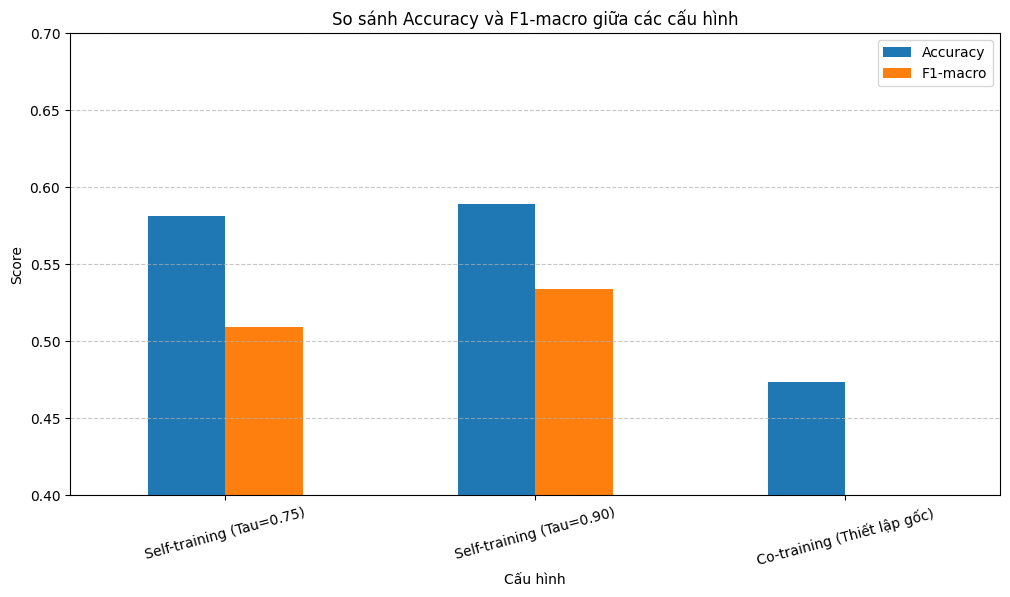

In [20]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# 1. Danh sách các file kết quả (Đảm bảo bạn đã chạy và lưu các file này)
configs = {
    "Baseline (5% Labeled)": "metrics.json",
    "Self-training (Tau=0.75)": "metrics_self_tau_0.75.json",
    "Self-training (Tau=0.90)": "metrics_self_tau_0.90.json",
    "Co-training (Thiết lập gốc)": "metrics_co_training.json"
}

def load_metrics(label, fname):
    path = PROJECT_ROOT / "data" / "processed" / fname
    if not path.exists(): return None
    with open(path, 'r', encoding='utf-8') as f:
        d = json.load(f)
        m = d.get('test_metrics', d.get('report', {}))
        return {
            "Cấu hình": label,
            "Accuracy": m.get('accuracy'),
            "F1-macro": m.get('f1_macro', m.get('macro avg', {}).get('f1-score'))
        }

# 2. Tạo bảng so sánh
table_data = []
for label, fname in configs.items():
    res = load_metrics(label, fname)
    if res: table_data.append(res)

df_req3 = pd.DataFrame(table_data)

print("="*60)
print("BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM (YÊU CẦU 3)")
print("="*60)
display(df_req3)

# 3. Vẽ biểu đồ so sánh
df_req3.set_index('Cấu hình').plot(kind='bar', figsize=(12, 6))
plt.title("So sánh Accuracy và F1-macro giữa các cấu hình")
plt.ylabel("Score")
plt.ylim(0.4, 0.7)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

✅ Đã tìm thấy file: c:\Users\Speedyservice\air_guard\notebooks\..\data\processed\metrics_self_tau_0.75.json
   -> Đã trích xuất Baseline từ Iteration 0: Acc=0.7226
✅ Đã tìm thấy file: c:\Users\Speedyservice\air_guard\notebooks\..\data\processed\metrics_co_training.json


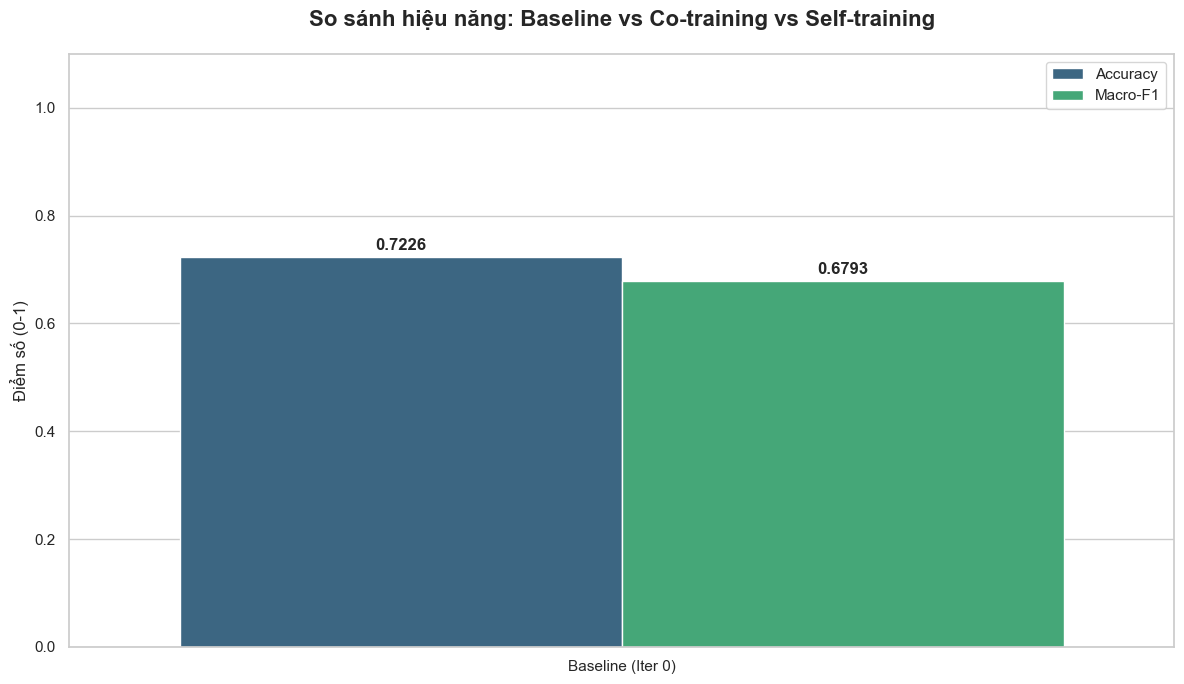

In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from pathlib import Path

# --- CẤU HÌNH ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# ==============================================================================
# 1. TỰ ĐỘNG TÌM ĐÚNG ĐƯỜNG DẪN DỮ LIỆU
# ==============================================================================
# Dựa trên ảnh cấu trúc folder: notebooks/runs -> data/processed nằm cách 2 cấp
current_dir = Path(os.getcwd())
possible_paths = [
    current_dir / "../../data/processed",  # Chuẩn cho notebook/runs
    current_dir / "../data/processed",
    current_dir / "data/processed",
    Path("data/processed")
]

DATA_DIR = None
for p in possible_paths:
    if p.exists() and (p / "metrics_self_tau_0.75.json").exists():
        DATA_DIR = p
        break

if DATA_DIR:
    print(f"✅ Đã tìm thấy thư mục dữ liệu: {DATA_DIR.resolve()}")
else:
    print("⚠️ Không tự tìm thấy folder. Đang dùng đường dẫn mặc định.")
    DATA_DIR = Path("../../data/processed")

# ==============================================================================
# 2. HÀM TRÍCH XUẤT DỮ LIỆU THÔNG MINH (SMART EXTRACT)
# ==============================================================================
def smart_extract(filename, metric_type='acc'):
    """
    Tìm mọi ngóc ngách trong file để lấy dữ liệu.
    Ưu tiên: Test Metric -> Last Iteration Metric -> 0
    """
    path = DATA_DIR / filename
    if not path.exists():
        print(f"❌ Không tìm thấy file: {filename}")
        return 0

    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
        # 1. Định nghĩa các tên khóa có thể (Ưu tiên Test)
        if metric_type == 'acc':
            test_keys = ['test_accuracy', 'test_acc', 'accuracy', 'acc']
            hist_keys = ['val_accuracy', 'val_acc', 'accuracy', 'acc']
        else:
            test_keys = ['test_f1_macro', 'test_f1', 'f1_macro', 'f1']
            hist_keys = ['val_f1_macro', 'val_f1', 'f1_macro', 'f1']

        # 2. Tìm ở lớp ngoài cùng (Level 0) hoặc trong 'test_metrics'
        # Check root
        for k in test_keys:
            if k in data and isinstance(data[k], (int, float)) and data[k] > 0:
                return data[k]
        
        # Check 'test_metrics' sub-dict
        if 'test_metrics' in data:
            for k in test_keys:
                if k in data['test_metrics'] and data['test_metrics'][k] > 0:
                    return data['test_metrics'][k]

        # 3. CỨU CÁNH: Lấy vòng lặp CUỐI CÙNG trong lịch sử (History)
        # (Dành cho trường hợp file không ghi kết quả Test riêng ở ngoài)
        if 'history' in data and isinstance(data['history'], list) and len(data['history']) > 0:
            last_iter = data['history'][-1] # Lấy vòng cuối cùng
            for k in hist_keys:
                if k in last_iter:
                    print(f"   ℹ️ {filename}: Lấy dữ liệu từ vòng lặp cuối (Iter {len(data['history'])})")
                    return last_iter[k]

    except Exception as e:
        print(f"⚠️ Lỗi đọc file {filename}: {e}")
    
    return 0

# ==============================================================================
# 3. TỔNG HỢP DỮ LIỆU
# ==============================================================================
stats = []

# --- A. BASELINE (Lấy từ Vòng 0 của Self-Training) ---
path_self = DATA_DIR / "metrics_self_tau_0.75.json"
if path_self.exists():
    with open(path_self, 'r') as f:
        d = json.load(f)
        if 'history' in d and len(d['history']) > 0:
            iter0 = d['history'][0]
            base_acc = iter0.get('val_accuracy', iter0.get('accuracy', 0))
            base_f1 = iter0.get('val_f1_macro', iter0.get('macro_f1', 0))
            stats.append({'Mô hình': 'Baseline (Iter 0)', 'Giá trị': base_acc, 'Độ đo': 'Accuracy'})
            stats.append({'Mô hình': 'Baseline (Iter 0)', 'Giá trị': base_f1, 'Độ đo': 'Macro-F1'})

# --- B. SELF-TRAINING (BEST) ---
acc = smart_extract("metrics_self_tau_0.75.json", 'acc')
f1 = smart_extract("metrics_self_tau_0.75.json", 'f1')
if acc > 0:
    stats.append({'Mô hình': 'Self-Training (Best)', 'Giá trị': acc, 'Độ đo': 'Accuracy'})
    stats.append({'Mô hình': 'Self-Training (Best)', 'Giá trị': f1, 'Độ đo': 'Macro-F1'})

# --- C. CO-TRAINING ---
acc = smart_extract("metrics_co_training.json", 'acc')
f1 = smart_extract("metrics_co_training.json", 'f1')
if acc > 0:
    stats.append({'Mô hình': 'Co-Training', 'Giá trị': acc, 'Độ đo': 'Accuracy'})
    stats.append({'Mô hình': 'Co-Training', 'Giá trị': f1, 'Độ đo': 'Macro-F1'})

# ==============================================================================
# 4. VẼ BIỂU ĐỒ
# ==============================================================================
if not stats:
    print("\n❌ Vẫn chưa lấy được dữ liệu. Hãy kiểm tra lại tên file JSON.")
else:
    df = pd.DataFrame(stats)
    
    # Thứ tự hiển thị
    order = ['Baseline (Iter 0)', 'Co-Training', 'Self-Training (Best)']
    
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=df, x='Mô hình', y='Giá trị', hue='Độ đo', 
                     palette='viridis', 
                     order=[o for o in order if o in df['Mô hình'].unique()])

    plt.title('So sánh hiệu năng: Baseline vs Co-training vs Self-training', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylim(0, 1.1)
    plt.ylabel('Điểm số (0-1)')
    plt.xlabel('')
    plt.legend(loc='upper right')

    # Hiển thị số liệu
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', padding=3, fontweight='bold')

    plt.tight_layout()
    plt.show()
    print("✅ Đã vẽ xong biểu đồ với đầy đủ 3 cột!")